In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['train.zip', 'train.csv', 'test.zip', 'test', 'train', 'sample_submission.csv', '.ipynb_checkpoints']


In [2]:
# Import the training data
train = pd.read_csv("./input/train.csv")
print(train.head())

                                     Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18


In [3]:
# Map of the targets
subcell_locs = {
    0:  "Nucleoplasm", 
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center" ,  
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",
    8:  "Peroxisomes",
    9:  "Endosomes",
    10:  "Lysosomes",
    11:  "Intermediate filaments",   
    12:  "Actin filaments",
    13:  "Focal adhesion sites",   
    14:  "Microtubules",
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",
    18:  "Microtubule organizing center",  
    19:  "Centrosome",
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions", 
    23:  "Mitochondria",
    24:  "Aggresome",
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings" 
}

In [4]:
from scipy.misc import imread, imresize
from skimage.transform import resize
import skimage.io

# Based off of this kernal: https://www.kaggle.com/ashishpatel26/two-branch-inceptionv2lb-0-3
class DataGenerator:
    def __init__(self):
        self.image_generator =  ImageDataGenerator(
                                     vertical_flip=True,
                                     horizontal_flip=True,
                                     rotation_range=180,
                                     fill_mode='reflect')
        
    def create_training(self, dataset, batch_size, shape):
        while True:
            random_indexes = np.random.choice(len(dataset), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            
            for i, index in enumerate(random_indexes):
                image = self.load_image(dataset[index]['path'], (299, 299))
                batch_images[i] = image
                batch_labels[i][dataset[index]['labels']] = 1
            
            yield batch_images, batch_labels
            
    
    def load_image(self, path, shape):
        image_red_ch = skimage.io.imread(path+'_red.png')
        image_yellow_ch = skimage.io.imread(path+'_yellow.png')
        image_green_ch = skimage.io.imread(path+'_green.png')
        image_blue_ch = skimage.io.imread(path+'_blue.png')

#         image_red_ch += (image_yellow_ch/2).astype(np.uint8) 
#         image_green_ch += (image_yellow_ch/2).astype(np.uint8)

        image = np.stack((
            image_red_ch, 
            image_green_ch, 
            image_blue_ch,
            image_yellow_ch), -1)
        image = resize(image, (shape[0], shape[1]), mode='reflect')
        return image

In [5]:
# Image Generator for Data
from keras.preprocessing.image import ImageDataGenerator

path_to_train = './input/train/'

train_dataset_info = []
for name, labels in zip(train['Id'], train['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

print(train_dataset_info)

train_directory = "./input/train/"
test_directory = "./input/test/"
resume_weights = './models/transfer.model'


[{'path': './input/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])}
 {'path': './input/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', 'labels': array([7, 1, 2, 0])}
 {'path': './input/train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([5])}
 ...
 {'path': './input/train/fff189d8-bbab-11e8-b2ba-ac1f6b6435d0', 'labels': array([7])}
 {'path': './input/train/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([25,  2, 21])}
 {'path': './input/train/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0', 'labels': array([2, 0])}]


Using TensorFlow backend.


/home/littlefield/.conda/envs/tensorflow-gpu3-clone/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


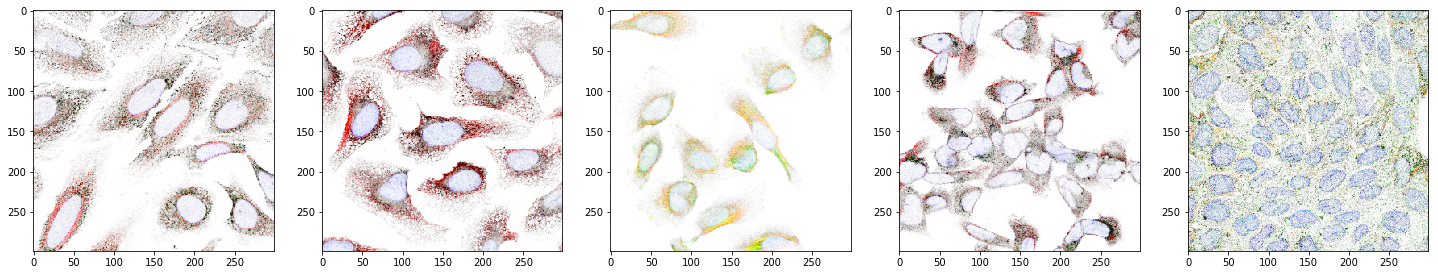

In [6]:
# Display random images in training set
train_datagen = DataGenerator()
generator = train_datagen.create_training(train_dataset_info, 5, (299, 299, 4))

images, labels = next(generator)
fig, ax = plt.subplots(1, 5, figsize=(25,15))
for i in range(5):
    ax[i].imshow(images[i])


In [7]:
from itertools import chain
from collections import Counter

# from https://www.kaggle.com/kmader/rgb-transfer-learning-with-inceptionv3-for-protein
train['target_list'] = train['Target'].map(lambda x: [int(a) for a in x.split(' ')])
all_labels = list(chain.from_iterable(train['target_list'].values))
c_val = Counter(all_labels)
n_keys = c_val.keys()
max_idx = max(n_keys)
train['target_vec'] = train['target_list'].map(lambda ck: [i in ck for i in range(max_idx+1)])

from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train, 
                 test_size = 0.2, 
                  # hack to make stratification work                  
                 stratify = train['Target'].map(lambda x: x[:3] if '27' not in x else '0'))
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

train_dataset_info = []
for name, labels in zip(train_df['Id'], train_df['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)
valid_dataset_info = []
for name, labels in zip(valid_df['Id'], valid_df['Target'].str.split(' ')):
    valid_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
valid_dataset_info = np.array(valid_dataset_info)
print(train_dataset_info.shape, valid_dataset_info.shape)

24857 training masks
6215 validation masks
(24857,) (6215,)


In [8]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

### ConvPool-CNN

In [9]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers.merge import concatenate
from keras.layers import Activation, Dense, Dropout, Multiply, Input, GlobalAveragePooling2D, Flatten, Conv2D, Concatenate, ReLU, LeakyReLU, BatchNormalization, MaxPooling2D, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras import metrics
from keras.optimizers import Adam  
from keras import backend as K


def conv_pool_cnn(model_input, n_out):
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(28, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='sigmoid')(x)
    
    model = Model(model_input, x, name='conv_pool_cnn')
    
    return model

protein_model_input = Input((299, 299, 4))
protein_classes = len(labels)

In [10]:
def compile_and_train(model, training_generator, validation_generator, epochs=4, batch_size=15):
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc']) 
    filepath = './models/' + model.name + '.weights'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_weights_only=True,
                                                 save_best_only=True, mode='auto', period=1)
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch= len(train_df)//batch_size,
        validation_data=validation_generator,
        validation_steps= len(valid_df)//batch_size,
        epochs=epochs, 
        verbose=1,
        callbacks=[checkpoint],
    )
    

In [11]:
conv_pool_cnn_model = conv_pool_cnn(protein_model_input, protein_classes)
conv_pool_cnn_model.summary()
conv_pool_cnn_model.load_weights('./models/conv_pool_cnn.weights')
print()
print()

# create train and valid datagens
batch_size = 32
train_generator = train_datagen.create_training(
    train_dataset_info, batch_size, (299,299,4))
validation_generator = train_datagen.create_training(
    valid_dataset_info, batch_size, (299,299,4))

# compile_and_train(conv_pool_cnn_model, train_generator, validation_generator, epochs=20, batch_size=batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 299, 299, 96)      3552      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 299, 299, 96)      83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 299, 299, 96)      83040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 96)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 149, 149, 192)     166080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 149, 149, 192)     331968    
__________

In [12]:
submit = pd.read_csv('./input/sample_submission.csv')

predicted = []
from tqdm import tqdm_notebook
from tqdm import tqdm
threshold = 0.4
for name in tqdm(submit['Id']):
    path = os.path.join('./input/test/', name)
    image1 = train_datagen.load_image(path, (299,299,4))
    score_predict = conv_pool_cnn_model.predict(image1[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict >= threshold]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
    
submit['Predicted'] = predicted
submit.to_csv('submission_conv-cnn.csv', index=False)

  0%|          | 0/11702 [00:00<?, ?it/s]/home/littlefield/.conda/envs/tensorflow-gpu3-clone/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 11702/11702 [07:23<00:00, 26.39it/s]


In [13]:
submit

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 4 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,0 2 21 25


### Individual ConvPool-CNN Score: 0.381

### All CNN

In [12]:
def all_cnn(model_input, n_out):
    
    x = Conv2D(96, kernel_size=(3, 3), activation='relu', padding = 'same')(model_input)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(96, (3, 3), activation='relu', padding = 'same', strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same', strides = 2)(x)
    x = Conv2D(192, (3, 3), activation='relu', padding = 'same')(x)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Conv2D(28, (1, 1))(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='sigmoid')(x)
        
    model = Model(model_input, x, name='all_cnn')
    
    return model

In [13]:
all_cnn_model = all_cnn(protein_model_input, protein_classes)
all_cnn_model.summary()
all_cnn_model.load_weights('./models/all_cnn.weights')
# Stopped running after iteration 12, 8 additional iterations are needed
# _ = compile_and_train(all_cnn_model, train_generator, validation_generator, epochs=8, batch_size=batch_size)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 4)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 299, 299, 96)      3552      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 299, 299, 96)      83040     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 150, 150, 96)      83040     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 150, 150, 192)     166080    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 150, 150, 192)     331968    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 192)       331968    
__________

In [16]:
submit = pd.read_csv('./input/sample_submission.csv')

predicted = []
from tqdm import tqdm_notebook
from tqdm import tqdm
threshold = 0.6
for name in tqdm(submit['Id']):
    path = os.path.join('./input/test/', name)
    image1 = train_datagen.load_image(path, (299,299,4))
    score_predict = all_cnn_model.predict(image1[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict >= threshold]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
    
submit['Predicted'] = predicted
submit.to_csv('submission_all-cnn.csv', index=False)

100%|██████████| 11702/11702 [07:06<00:00, 27.34it/s]


### Individual All-CNN Score: 0.321

### Network in Network

In [14]:
def nin_cnn(model_input, n_out):
    
    #mlpconv block 1
    x = Conv2D(32, (5, 5), activation='relu',padding='valid')(model_input)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.5)(x)
    
    #mlpconv block2
    x = Conv2D(64, (3, 3), activation='relu',padding='valid')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.5)(x)
    
    #mlpconv block3
    x = Conv2D(128, (3, 3), activation='relu',padding='valid')(x)
    x = Conv2D(32, (1, 1), activation='relu')(x)
    x = Conv2D(28, (1, 1))(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Activation(activation='sigmoid')(x)
    
    model = Model(model_input, x, name='nin_cnn')
    
    return model

In [15]:
nin_cnn_model = nin_cnn(protein_model_input, protein_classes)
nin_cnn_model.summary()
nin_cnn_model.load_weights("./models/nin_cnn.weights")
# Previously ran 4 iterations, 16 more need to be run.
#_ = compile_and_train(nin_cnn_model, train_generator, validation_generator, epochs=16, batch_size=batch_size)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 4)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 295, 295, 32)      3232      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 295, 295, 32)      1056      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 295, 295, 32)      1056      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 147, 147, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 147, 147, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 145, 145, 64)      18496     
__________

In [ ]:
submit = pd.read_csv('./input/sample_submission.csv')

predicted = []
from tqdm import tqdm_notebook
from tqdm import tqdm
threshold = 0.6
for name in tqdm(submit['Id']):
    path = os.path.join('./input/test/', name)
    image1 = train_datagen.load_image(path, (299,299,4))
    score_predict = nin_cnn_model.predict(image1[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict >= threshold]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
    
submit['Predicted'] = predicted
submit.to_csv('submission_nin-cnn.csv', index=False)

100%|██████████| 11702/11702 [06:10<00:00, 30.41it/s]


### Ensemble Model

In [17]:
conv_pool_cnn_model = conv_pool_cnn(protein_model_input, protein_classes)
all_cnn_model = all_cnn(protein_model_input, protein_classes)
nin_cnn_model = nin_cnn(protein_model_input, protein_classes)

conv_pool_cnn_model.load_weights('models/conv_pool_cnn.weights')
all_cnn_model.load_weights('models/all_cnn.weights')
nin_cnn_model.load_weights('models/nin_cnn.weights')

models = [conv_pool_cnn_model, all_cnn_model, nin_cnn_model]

In [18]:
from keras.layers import Average
def ensemble(models, model_input):
    
    outputs = [model.outputs[0] for model in models]
    y = Average()(outputs)
    
    model = Model(model_input, y, name='ensemble')
    
    return model

In [19]:
ensemble_model = ensemble(models, protein_model_input)

submit = pd.read_csv('./input/sample_submission.csv')

predicted = []
from tqdm import tqdm_notebook
from tqdm import tqdm
threshold = 0.4
for name in tqdm(submit['Id']):
    path = os.path.join('./input/test/', name)
    image1 = train_datagen.load_image(path, (299,299,4))
    score_predict = ensemble_model.predict(image1[np.newaxis])[0]
    label_predict = np.arange(28)[score_predict >= threshold]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)
    
submit['Predicted'] = predicted
submit.to_csv('submission_ensemble-cnn.csv', index=False)

  0%|          | 0/11702 [00:00<?, ?it/s]/home/littlefield/.conda/envs/tensorflow-gpu3-clone/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 11702/11702 [08:53<00:00, 21.94it/s]


In [20]:
submit

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 21 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,
5,00109f6a-bac8-11e8-b2b7-ac1f6b6435d0,4
6,001765de-bacd-11e8-b2b8-ac1f6b6435d0,0 4 25
7,0018641a-bac9-11e8-b2b8-ac1f6b6435d0,0 25
8,00200f22-bad7-11e8-b2b9-ac1f6b6435d0,0
9,0026f154-bac6-11e8-b2b7-ac1f6b6435d0,2 21 25
